This notebook is for downloading the MACA v2 metdata, harmonizing the different data arrays with different resolutions, and coding thresholds for suitability ratings to each of the layers. Additionally, a fuzzly logic model would be applied to designate each cell on a 0-1 continuous suitability scale for plotting and identification of more- and less-suitable areas under different climate change scenarios. 

Because I have not yet gotten to these steps, this notebook contains only initial pseudocode. 

In [1]:
import os
import pathlib
import re
import zipfile
from io import BytesIO
from glob import glob
import requests

import earthaccess
import earthpy as et
import numpy as np
import pandas as pd
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
from math import floor, ceil

import xarray as xr
import rioxarray as rxr  #work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
from rasterio.mask import mask
import xrspatial # 
import warnings

c:\Users\chrmq\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
store -r pay_gdf uma_gdf nfs2_gdf srtm_das soil_das

In [ ]:
#http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/HadGEM2-ES365/macav2metdata_pr_HadGEM2-ES365_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc.html

In [ ]:
# hard code example for MACA precipitation
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

maca1_url = (
    'http://thredds.northwestknowledge.net:8080/thredds/dodsC/'
    'MACAV2/HadGEM2-ES365/macav2metdata_pr_HadGEM2-ES365_r1i1p1'
    '_rcp85_2071_2075_CONUS_monthly.nc')

maca1_da = xr.open_dataset(maca1_url).squeeze().precipitation
bounds1 = pay_gdf.to_crs(maca1_da.rio.crs).total_bounds
maca1_da = maca1_da.assign_coords(
    lon=("lon", [convert_longitude(l) for l in maca1_da.lon.values]))
maca1_da = maca1_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

In [ ]:
help(maca1_da.rio.set_spatial_dims)
bounds1 = pay_gdf.to_crs(maca1_da.rio.crs).total_bounds
#bounds1

#maca1_da.rio.clip_box(*bounds1)

<xarray.DataArray 'precipitation' (time: 60, lat: 28, lon: 56)> Size: 376kB
[94080 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 224B 44.44 44.48 44.52 44.56 ... 45.48 45.52 45.56
  * time     (time) object 480B 2071-01-15 00:00:00 ... 2075-12-15 00:00:00
  * lon      (lon) float64 448B -117.0 -117.0 -116.9 ... -114.8 -114.8 -114.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [23]:
nfs2_gdf.head()

,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,FORESTNAME,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
58,99041200010343,04,12,0412,Payette National Forest,2407296.569,1.113418,11.686712,"MULTIPOLYGON (((-115.21399 45.56972, -115.2137..."
92,99061400010343,06,14,0614,Umatilla National Forest,1498094.353,0.697580,15.051197,"MULTIPOLYGON (((-118.00972 45.61629, -118.0097..."


In [9]:
# Maca v2 metdata download
# Query multiple netcdf files of MACA data, convert longitude format 
# open the data, crop to the gdfs and compile into a list
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

gdf_dict = {'Payette NF': pay_gdf,
            'Umatilla NF': uma_gdf}

# Start an empty list for the data arrays
maca_da_list = []

# Loop over the sites, variables, and start_year values
for site_name, site_gdf in gdf_dict.items():
    for var in ['pr', 'tasmin', 'tasmax']:
        for start_year in [2051, 2071]:
            end_year = start_year + 4
            rcp = 'rcp85'
            maca_url = (
                'http://thredds.northwestknowledge.net:8080/thredds/dodsC/'
                f'MACAV2/HadGEM2-ES365/macav2metdata_{var}_HadGEM2-ES365_'
                f'r1i1p1_{rcp}_{start_year}_{end_year}_CONUS_monthly.nc')
            maca_da = xr.open_dataset(maca_url).squeeze()
            bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds
            maca_da = maca_da.assign_coords(
                lon=("lon", [convert_longitude(l) for l in maca_da.lon.values]))
            maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
            maca_da = maca_da.rio.clip_box(*bounds)
            maca_da_list.append(dict(
                site_name = site_name,
                variable = var,
                start_year = start_year,
                da=maca_da))
            
maca_df = pd.DataFrame(maca_da_list)

In [ ]:
# Split out the 2 time periods maca_df

,site_name,variable,start_year,da
0,Payette NF,pr,2051,[precipitation]
1,Payette NF,pr,2071,[precipitation]
2,Payette NF,tasmin,2051,[air_temperature]
3,Payette NF,tasmin,2071,[air_temperature]
4,Payette NF,tasmax,2051,[air_temperature]
5,Payette NF,tasmax,2071,[air_temperature]
6,Umatilla NF,pr,2051,[precipitation]
7,Umatilla NF,pr,2071,[precipitation]
8,Umatilla NF,tasmin,2051,[air_temperature]
9,Umatilla NF,tasmin,2071,[air_temperature]


In [ ]:
# Try merging the maca arrays together -- this doesn't work.
# It ran for >30 min
#maca_das_mrg = xr.merge(maca_da_list)

In [ ]:
maca_das_mrg = xr.combine_by_coords(data_objects=[maca_da_list], data_vars='all,
                                    coords='different')

In [ ]:


# Make a selection from the maca_df but don't print the da inside
maca_df[(maca_df.start_year==2051) & 
        (maca_df.variable=='pr')].drop('da', axis='columns')
maca_df.da.values[0]

<xarray.Dataset> Size: 377kB
Dimensions:        (lat: 28, time: 60, lon: 56)
Coordinates:
  * lat            (lat) float64 224B 44.44 44.48 44.52 ... 45.48 45.52 45.56
  * time           (time) object 480B 2051-01-15 00:00:00 ... 2055-12-15 00:0...
  * lon            (lon) float64 448B -117.0 -117.0 -116.9 ... -114.8 -114.7
    crs            int64 8B 0
Data variables:
    precipitation  (time, lat, lon) float32 376kB 62.85 66.07 ... 242.1 221.8
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [66]:
maca_df[(maca_df.start_year==2051) & (maca_df.variable=='pr') & (maca_df.site_name=='Payette NF')].da.values.item()

<xarray.Dataset> Size: 377kB
Dimensions:        (lat: 28, time: 60, lon: 56)
Coordinates:
  * lat            (lat) float64 224B 44.44 44.48 44.52 ... 45.48 45.52 45.56
  * time           (time) object 480B 2051-01-15 00:00:00 ... 2055-12-15 00:0...
  * lon            (lon) float64 448B -117.0 -117.0 -116.9 ... -114.8 -114.7
    crs            int64 8B 0
Data variables:
    precipitation  (time, lat, lon) float32 376kB ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [93]:
maca_2051_orig_da = (
    maca_df
    [(maca_df.start_year==2051) & (maca_df.variable=='pr') & (maca_df.site_name=='Payette NF')]
    .da.values.item().to_dataarray(dim='year')
    .rio.write_crs(4326)
    .rio.set_spatial_dims('lat', 'lon')
    .groupby('time.year')
    .sum()
    .min('year')
)
maca_2051_orig_da

<xarray.DataArray (lat: 28, lon: 56)> Size: 6kB
array([[689.67053, 702.5087 , 678.6937 , ..., 761.85455, 750.863  ,
        652.41656],
       [743.3993 , 747.25446, 725.5329 , ..., 917.0252 , 781.3251 ,
        703.2245 ],
       [805.21204, 739.93915, 782.69495, ..., 725.09424, 694.92926,
        701.32324],
       ...,
       [354.64636, 350.80585, 337.43558, ..., 883.8949 , 807.5884 ,
        715.6631 ],
       [362.87595, 378.6722 , 364.67603, ..., 904.1831 , 863.869  ,
        712.00275],
       [355.5989 , 369.64105, 357.05222, ..., 827.1728 , 759.49445,
        692.12244]], dtype=float32)
Coordinates:
  * lat          (lat) float64 224B 44.44 44.48 44.52 ... 45.48 45.52 45.56
  * lon          (lon) float64 448B -117.0 -117.0 -116.9 ... -114.8 -114.7
    crs          int64 8B 0
    spatial_ref  int64 8B 0

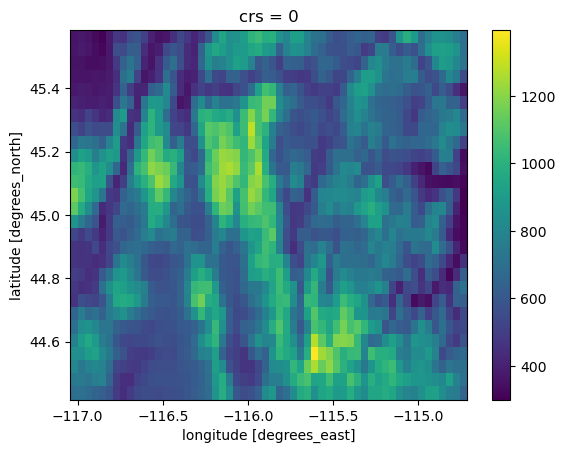

In [90]:
maca_2051_orig_da.plot()

In [94]:
maca_2051_orig_da.rio.crs

CRS.from_epsg(4326)

In [96]:
maca_2051_gridda = maca_2051_orig_da.rio.reproject_match(srtm_das)

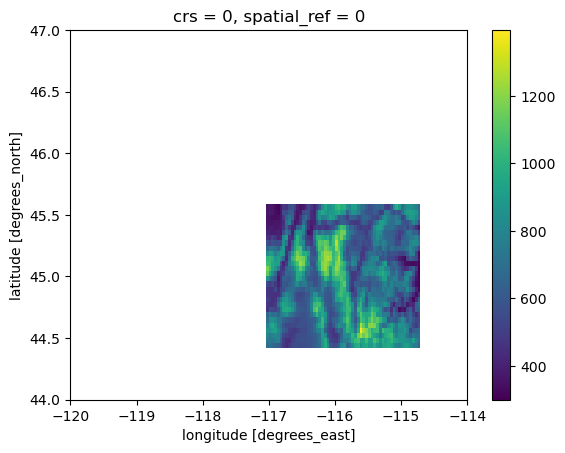

In [97]:
maca_2051_gridda.plot()

In [ ]:
def process_maca_da(rcp, df, row):
    site_rcp_da = (df.loc[row, 'da']
                        .rio.write_crs(4326)
                        .rio.set_spatial_dims('lat', 'lon'))
    site_rcp_yearly_precip_da = (grassland_rcp_da
                                      .groupby('time.year')
                                      .sum())

TypeError: 'FrozenMappingWarningOnValuesAccess' object is not callable

In [ ]:
# Maca v2 metdata download
# I would define a df or a dictionary with each combination of GCM, time period, and climate variable:
# The climate variables would be: Maximum temperature, mean temperature, and total precipitation
#
# I would select a single time period, 2060-2065. The GCM would be HadGEM2-ES365 from CMIP5. 
#

# Define the url template
maca_url_template = ( <format of filepath to .nc>

)

#Start an empty list for the urls
maca_url_list = []

# I would then accumulate all the data arrays covering 
# either of the forest gdfs. 
#for-loop to read in each .nc file
maca_ds = xr.open_dataset(maca_url_template)
maca_url_list.append(maca_ds)
maca_das

# Plot the data arrays
#maca_das.plot()

In [ ]:
# Convert MACA data to a data frame for aggregating


# Aggregation/resampling step 1: Calculate annual measures from the monthly data by resampling


# For example, compute averages for mean/max temperature and sum for precipitation

# Agg/resampling step 2: Average the annual estimates across the 5-year temporal range .

In [ ]:
# Necessary data checks go here. Review descriptive statistics for 
#
#
# Data visualization: Histograms for data checking

In [ ]:
# Data Harmonization phase: All raster data needs standardized


# Reproject the coarser raster data (MACA) to the rio.crs of the finer-scale data
# 

# Get all data arrays: SRTM, POLARIS, and MACA to an aligned raster grid
# 

# Combine the layers using rasterio


In [ ]:
# Define suitability thresholds for all variables

# Habitat suitability variables: Elevation, Soil pH, mean temp, max. temp, and 
#   total precipitation. 
#
# Elevation: 2,000-7,000 Ft
# Soil pH: ideal range 5.0 - 6.5
#
# Mean temperature: Average ann. max: 29C/84F; Avg ann mean: 7C/45F
# Max temp: Abs ann max: 41C/106F (Schmidt & Shearer)
# 
# Precipitation: Average ann. total precip: 710mm/28in up to 810mm in the southern part of its range. 
# Extreme precip range is between 460 mm (18in) and 1270mm (50 in)

In [ ]:
# Code and run a suitability model using fuzzy logic
# 
# I would divide the ranges of each of the habitat variables into scores where
# a high score is given to the middle part of the distributions where the current
# average/median conditions are. Scores would go down in increments as a given
# value got farther away on either side of the optimal range. 
# For example, looking at precipitation, I would perhaps group 25 - 33 inches of rain
# as the highest score, say 1.0. (I would allow more precipitation because this is generally
# a good thing for trees.) Then 22-24 in and 34-35 in of annual precip would be 0.8, and so on. 
# Very low values of annual precip (<18in) would be scored very low. 
#
# Multiply the scores for all the habitat variables for each cell

In [ ]:
# Plot the new raster layer with the suitability scores, ranging 0.0-1.0.
#
# I would probably use hvplot to get an interactive plot, and choose a 
# colormap that would reflect suitability, maybe green-to-orange or green 
# to brown scale, with green representing higher suitability. 
#
#

After running the fuzzy logic model and multiplying across the layers, I would plot the suitability maps for my two national forests. As well, I would interpret the spatial variation in the scores across each grassland. I would even consider having a third comparison layer, and that would be using back-casted climate estimates for a recent time period, say 2010-2015 if available. Then I would have a baseline suitability map for these two forests, and this would help to interpret how much change there was in the climate change projections for 2060-65 (fifty years later).


### References

Schmidt, W.C., Shearer, R.C. "Western Larch". United States Forest Service. Retrieved from: https://www.srs.fs.usda.gov/pubs/misc/ag_654/volume_1/larix/occidentalis.htm

Oregeon Forest Resources Institute. "Western Larch". Retrieved from: https://oregonforests.org/forest-types-tree-guide/tree-variety/western-larch.